I'm running this chapter using mxnet and not pytorch.  This isn't what I want to be doing, but the book only offers this chapter in mxnet, so I have to go with it.

In [3]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [4]:
def get_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=ctx)

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                np.zeros(num_hiddens, ctx=ctx))

    W_xz, W_hz, b_z = three()  # Update gate parameter
    W_xr, W_hr, b_r = three()  # Reset gate parameter
    W_xh, W_hh, b_h = three()  # Candidate hidden state parameter
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Attach gradients
    params = [W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

In [5]:
def init_gru_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx), )

In [6]:
def gru(inputs, state, params):
    W_xz, W_hz, b_z, W_xr, W_hr, b_r, W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        Z = npx.sigmoid(np.dot(X, W_xz) + np.dot(H, W_hz) + b_z)
        R = npx.sigmoid(np.dot(X, W_xr) + np.dot(H, W_hr) + b_r)
        H_tilda = np.tanh(np.dot(X, W_xh) + np.dot(R * H, W_hh) + b_h)
        H = Z * H + (1 - Z) * H_tilda
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H,)

KeyboardInterrupt: 

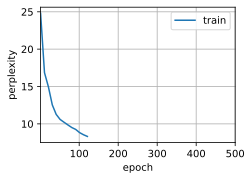

In [7]:
vocab_size, num_hiddens, ctx = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, ctx, get_params,
                            init_gru_state, gru)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

Again, I'm not on the gpu, so this is taking a crazy amount of time.  For the next few graphs in this chapter, I will probably end the training early.  The book outputs the full graph.

perplexity 1.1, 8264.5 tokens/sec on cpu(0)
time traveller  it s against reason said filby  what reason said
traveller  it s against reason said filby  what reason said


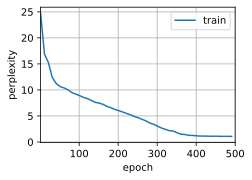

In [8]:
gru_layer = rnn.GRU(num_hiddens)
model = d2l.RNNModel(gru_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

This last one is supposed to be much faster than the one before it, so I'm going to let it run to completion.  

In [9]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [10]:
def get_lstm_params(vocab_size, num_hiddens, ctx):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return np.random.normal(scale=0.01, size=shape, ctx=ctx)

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                np.zeros(num_hiddens, ctx=ctx))

    W_xi, W_hi, b_i = three()  # Input gate parameters
    W_xf, W_hf, b_f = three()  # Forget gate parameters
    W_xo, W_ho, b_o = three()  # Output gate parameters
    W_xc, W_hc, b_c = three()  # Candidate cell parameters
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = np.zeros(num_outputs, ctx=ctx)
    # Attach gradients
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.attach_grad()
    return params

In [11]:
def init_lstm_state(batch_size, num_hiddens, ctx):
    return (np.zeros(shape=(batch_size, num_hiddens), ctx=ctx),
            np.zeros(shape=(batch_size, num_hiddens), ctx=ctx))

In [12]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = npx.sigmoid(np.dot(X, W_xi) + np.dot(H, W_hi) + b_i)
        F = npx.sigmoid(np.dot(X, W_xf) + np.dot(H, W_hf) + b_f)
        O = npx.sigmoid(np.dot(X, W_xo) + np.dot(H, W_ho) + b_o)
        C_tilda = np.tanh(np.dot(X, W_xc) + np.dot(H, W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * np.tanh(C)
        Y = np.dot(H, W_hq) + b_q
        outputs.append(Y)
    return np.concatenate(outputs, axis=0), (H, C)

KeyboardInterrupt: 

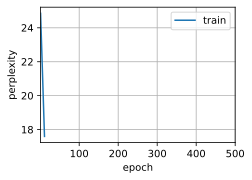

In [13]:
vocab_size, num_hiddens, ctx = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, ctx, get_lstm_params,
                            init_lstm_state, lstm)
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

this is the "concise implementation" so it should run faster

perplexity 1.2, 5389.8 tokens/sec on cpu(0)
time traveller  it s against reason said filby  what reason said
traveller for so it will be convenient to speak of him was 


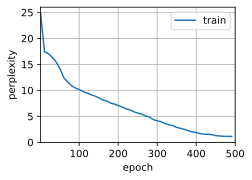

In [14]:
lstm_layer = rnn.LSTM(num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

this is still far too slow, so I might shut it down early

In [15]:
from d2l import mxnet as d2l
from mxnet import npx
from mxnet.gluon import rnn
npx.set_np()

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [16]:
vocab_size, num_hiddens, num_layers, ctx = len(vocab), 256, 2, d2l.try_gpu()
lstm_layer = rnn.LSTM(num_hiddens, num_layers)
model = d2l.RNNModel(lstm_layer, len(vocab))

This did not run like it should have.  I'm not sure what went wrong, but perplexity should have continued to fall for a while

perplexity 16.8, 4874.8 tokens/sec on cpu(0)
time traveller aa ae aa ae aa ae aa ae aa ae aa ae aa ae aa ae a
traveller aa ae aa ae aa ae aa ae aa ae aa ae aa ae aa ae a


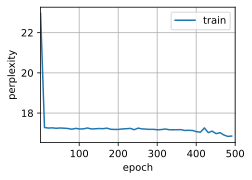

In [17]:
num_epochs, lr = 500, 2
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

KeyboardInterrupt: 

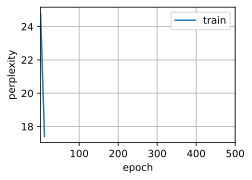

In [18]:
from d2l import mxnet as d2l
from mxnet import npx
from mxnet.gluon import rnn
npx.set_np()

# Load data
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)
# Define the model
vocab_size, num_hiddens, num_layers, ctx = len(vocab), 256, 2, d2l.try_gpu()
lstm_layer = rnn.LSTM(num_hiddens, num_layers, bidirectional=True)
model = d2l.RNNModel(lstm_layer, len(vocab))
# Train the model
num_epochs, lr = 500, 1
d2l.train_ch8(model, train_iter, vocab, lr, num_epochs, ctx)

This last model applied bidirectional RNNs in a situation that definitely did not need to be bidirectional.  Bidirectional RNNs are rarely used in only certain applications.

Also they have pytorch for this section, so I am switching to that

In [19]:
from d2l import torch as d2l
import torch
import os

In [20]:
#@save
d2l.DATA_HUB['fra-eng'] = (d2l.DATA_URL + 'fra-eng.zip',
                           '94646ad1522d915e7b0f9296181140edcf86a4f5')

#@save
def read_data_nmt():
    data_dir = d2l.download_extract('fra-eng')
    with open(os.path.join(data_dir, 'fra.txt'), 'r') as f:
        return f.read()

raw_text = read_data_nmt()
print(raw_text[0:106])

Go.	Va !
Hi.	Salut !
Run!	Coursâ€¯!
Run!	Courezâ€¯!
Who?	Qui ?
Wow!	Ã‡a alorsâ€¯!
Fire!	Au feu !
Help!	Ã€ 


I don't know much about French, but I don't think that some of these characters are right.  

In [21]:
#@save
def preprocess_nmt(text):
    def no_space(char, prev_char):
        return char in set(',.!') and prev_char != ' '

    text = text.replace('\u202f', ' ').replace('\xa0', ' ').lower()
    out = [' ' + char if i > 0 and no_space(char, text[i-1]) else char
           for i, char in enumerate(text)]
    return ''.join(out)

text = preprocess_nmt(raw_text)
print(text[0:95])

go .	va !
hi .	salut !
run !	coursâ€¯ !
run !	courezâ€¯ !
who?	qui ?
wow !	ã‡a alorsâ€¯ !
fire 


In [22]:
#@save
def tokenize_nmt(text, num_examples=None):
    source, target = [], []
    for i, line in enumerate(text.split('\n')):
        if num_examples and i > num_examples:
            break
        parts = line.split('\t')
        if len(parts) == 2:
            source.append(parts[0].split(' '))
            target.append(parts[1].split(' '))
    return source, target

source, target = tokenize_nmt(text)
source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['coursâ€¯', '!']])

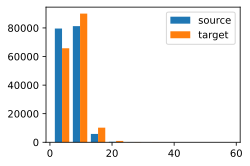

In [23]:
d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
d2l.plt.legend(loc='upper right');

In [24]:
src_vocab = d2l.Vocab(source, min_freq=3,
                      reserved_tokens=['<pad>', '<bos>', '<eos>'])
len(src_vocab)

9141

In [25]:
#@save
def truncate_pad(line, num_steps, padding_token):
    if len(line) > num_steps:
        return line[:num_steps]  # Trim
    return line + [padding_token] * (num_steps - len(line))  # Pad

truncate_pad(src_vocab[source[0]], 10, src_vocab['<pad>'])

[47, 4, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
#@save
def build_array(lines, vocab, num_steps, is_source):
    lines = [vocab[l] for l in lines]
    if not is_source:
        lines = [[vocab['<bos>']] + l + [vocab['<eos>']] for l in lines]
    array = torch.tensor([truncate_pad(
        l, num_steps, vocab['<pad>']) for l in lines])
    valid_len = (array != vocab['<pad>']).sum(dim=1)
    return array, valid_len

In [27]:
#@save
def load_data_nmt(batch_size, num_steps, num_examples=1000):
    text = preprocess_nmt(read_data_nmt())
    source, target = tokenize_nmt(text, num_examples)
    src_vocab = d2l.Vocab(source, min_freq=3,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    tgt_vocab = d2l.Vocab(target, min_freq=3,
                          reserved_tokens=['<pad>', '<bos>', '<eos>'])
    src_array, src_valid_len = build_array(
        source, src_vocab, num_steps, True)
    tgt_array, tgt_valid_len = build_array(
        target, tgt_vocab, num_steps, False)
    data_arrays = (src_array, src_valid_len, tgt_array, tgt_valid_len)
    data_iter = d2l.load_array(data_arrays, batch_size)
    return src_vocab, tgt_vocab, data_iter

In [28]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, num_steps=8)
for X, X_vlen, Y, Y_vlen in train_iter:
    print('X:', X.type(torch.int32))
    print('valid lengths for X:', X_vlen)
    print('Y:', Y.type(torch.int32))
    print('valid lengths for Y:', Y_vlen)
    break

X: tensor([[12,  0,  6,  1,  1,  1,  1,  1],
        [ 7,  0,  4,  1,  1,  1,  1,  1]], dtype=torch.int32)
valid lengths for X: tensor([3, 3])
Y: tensor([[2, 9, 0, 5, 3, 1, 1, 1],
        [2, 6, 7, 0, 4, 3, 1, 1]], dtype=torch.int32)
valid lengths for Y: tensor([5, 6])


In [29]:
from torch import nn

#@save
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Encoder, self).__init__(**kwargs)

    def forward(self, X, *args):
        raise NotImplementedError

In [30]:
#@save
class Decoder(nn.Module):
    """The base decoder interface for the encoder-decoder architecture."""
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)

    def init_state(self, enc_outputs, *args):
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

In [31]:
#@save
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)
        dec_state = self.decoder.init_state(enc_outputs, *args)
        return self.decoder(dec_X, dec_state)

In [32]:
from d2l import torch as d2l
import torch
from torch import nn

In [33]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)

    def forward(self, X, *args):
        X = self.embedding(X)  # X shape: (batch_size, seq_len, embed_size)
        # RNN needs first axes to be timestep, i.e., seq_len
        X = X.permute(1, 0, 2)
        out, state = self.rnn(X) # When state is not mentioned, it defaults to zeros
        # out shape: (seq_len, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens),
        # where "state" contains the hidden state and the memory cell
        return out, state

In [34]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [35]:
len(state), state[0].shape, state[1].shape

(2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [36]:
#@save
class Seq2SeqDecoder(d2l.Decoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        X = self.embedding(X).permute(1, 0, 2)
        out, state = self.rnn(X, state)
        # Make the batch to be the first dimension to simplify loss computation
        out = self.dense(out).permute(1, 0, 2)
        return out, state

In [37]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8,
                         num_hiddens=16, num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
out, state = decoder(X, state)
out.shape, len(state), state[0].shape, state[1].shape

(torch.Size([4, 7, 10]), 2, torch.Size([2, 4, 16]), torch.Size([2, 4, 16]))

In [38]:
#@save
def sequence_mask(X, valid_len, value=0):
    output = X.clone()
    for count, matrix in enumerate(output):
        matrix[int(valid_len[count]):]=value
    return output

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [39]:
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

In [40]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    # pred shape: (batch_size, seq_len, vocab_size)
    # label shape: (batch_size, seq_len)
    # valid_len shape: (batch_size, )
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0,2,1), label)
        weighted_loss = (unweighted_loss*weights).mean(dim=1)
        return weighted_loss

In [41]:
loss = MaskedSoftmaxCELoss()
loss(torch.ones(3, 4, 10), torch.ones((3, 4), dtype=torch.long), torch.tensor([4, 2, 0]))

tensor([2.3026, 1.1513, 0.0000])

In [42]:
#@save
def train_s2s_ch9(model, data_iter, lr, num_epochs, device):
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.LSTM:
            for param in m._flat_weights_names:
                if "weight" in param:
                    torch.nn.init.xavier_uniform_(m._parameters[param])
    model.apply(xavier_init_weights)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    model.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], ylim=[0, 0.25])
    for epoch in range(1, num_epochs + 1):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # loss_sum, num_tokens
        for batch in data_iter:
            X, X_vlen, Y, Y_vlen = [x.to(device) for x in batch]
            Y_input, Y_label, Y_vlen = Y[:, :-1], Y[:, 1:], Y_vlen-1
            Y_hat, _ = model(X, Y_input, X_vlen, Y_vlen)
            l = loss(Y_hat, Y_label, Y_vlen)
            l.sum().backward() # Making the loss scalar for backward()
            d2l.grad_clipping(model, 1)
            num_tokens = Y_vlen.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if epoch % 10 == 0:
            animator.add(epoch, (metric[0]/metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

TypeError: unsupported operand type(s) for ** or pow(): 'NoneType' and 'int'

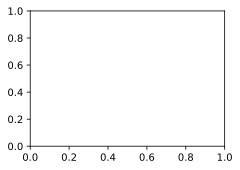

In [43]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.0
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

src_vocab, tgt_vocab, train_iter = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.EncoderDecoder(encoder, decoder)
train_s2s_ch9(model, train_iter, lr, num_epochs, device)

This is an interesting error.  I think something wasn't initialized properly that should have been initialized to be an int